# Simulation of electron-nuclear spin dynamics

This notebook allows to simulate the dynamics of a $Er^{3+}$ electron spin ($S = 1/2$) with a $^{183}W$ ($I = 1/2$) down to the pulse level using QuTip (https://qutip.org/docs/latest/).

The exact shape of the pulse used in the simulation is determined upon the experimental relaxation rate of the MW cavity, and can be freely modified by the user to simulate any case scenario.

In [1]:
from multiprocessing import Pool, cpu_count
from src.utility import *
from src.pulses import *
from src.plotting import*

%matplotlib inline
worker_count = max(cpu_count() - 1, 1)

## Introduction

The system considered is a tensor space of the electron spin S=1/2 and the nuclear spin I=1/2 subspaces.

The coupling of the intrinsic magnetic moment of the electron spin and the nuclear spin is called the hyperfine interaction. Since the magnetic moment of the electron spin is much larger than that of the nuclear spin, the electron strongly influences the dynamics of the surrounding nuclear spins. As a consequence, electrons can be used to manipulate them (see the figure below).

Here, flipping the electron spin (by applying a $\pi$ pulse) changes the quantization axis $\mathbf{m_{\uparrow \downarrow}}$ of the surrounding $^{183}W$ nuclear spins. By choosing the right period $2 \tau$ between the $\pi$ pulses, one can selectively address a single nuclear spin and flip its state. It is upon this technique that all dynamical decoupling sequences stem from.

<img src="figs/Quantization_axis_LB_CaWO4.jpg" width="600"/>

The static spin Hamiltonian comprises the electron and nuclear Zeeman interactions ($H_{EZ}$ and $H_{NZ}$ respectively) as well as the hyperfine interaction:

$$H_0 = H_{EZ} + H_{NZ} + H_{DD}$$

In the following, we choose to express the Hamiltonian exclusively in terms of angular frequencies (i.e. $H / \hbar$ which we will write simply as $H$). Using the secular approximation, the static Hamiltonian of the system in the rotating frame may be written as:

$$H_0 = \vec{\omega_S} \cdot \vec{S} + \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

where $A$ and $B$ are the secular hyperfine coupling constants.

By applying the rotating wave approximation, we can neglect the electron Zeeman interaction so that the static Hamiltonian becomes:

$$H_0 = \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

The total Hamiltonian $H$ comprises the static Hamiltonian $H_0$ as well as the time-dependent Hamiltonian $H_t$ which is simply:

$$H_t = f(t) \sigma_z$$

where $f: t \rightarrow f(t)$ is the pulse function to apply to the electron (which depends on the sequence considered).

#### References
* [Léo Balembois. Magnetic resonance of a single electron spin and its magnetic environment by photon counting. Université Paris-Saclay, 2023.](https://theses.hal.science/tel-04165482)
* [Arthur Schweiger and Gunnar Jeschke. Principles of pulse electron paramagnetic resonance. Oxford University Press, 2001.](https://global.oup.com/academic/product/principles-of-pulse-electron-paramagnetic-resonance-9780198506348?cc=fr&lang=en&)
* [T. H. Taminiau et al. Detection and Control of Individual Nuclear Spins Using a Weakly Coupled Electron Spin. Physical Review Letters 109.137602, 2012.](https://link.aps.org/doi/10.1103/PhysRevLett.109.137602)

### Parameters
Frequencies are given in MHz and durations in $\mu s$. Therefore, the time basis will be in $\mu s$.

In [2]:
# Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T

# Magnetic field
B0 = 0.447 # T
theta = 0*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us

# Hyperfine constants
A = 2*np.pi * 1e-3 * 40# 40 kHz
B = 2*np.pi * 1e-3 * 3.2# 3.2 kHz 
eta = np.arctan(B/(2*omega_L))

### Setup of the operators and the static Hamiltonian

In [3]:
S = 1/2
nS = int(2*S+1)
(Sx,Sy,Sz) = generate_S(S)

In [4]:
I = 1/2
nI = int(2*I+1)
(Ix,Iy,Iz) = generate_S(I)

In [5]:
# Local oscillator at 10 MHz
omega_LO = 2*np.pi*10
H_LO = tensor(omega_LO*Sz, qeye(nI))

# Nuclear Zeeman interaction
omega_Ix = 2*np.pi*mu_I/h*1e-6*B_field[0]
omega_Iy = 2*np.pi*mu_I/h*1e-6*B_field[1]
omega_Iz = 2*np.pi*mu_I/h*1e-6*B_field[2]
H_NZ = tensor(qeye(nS), omega_Ix*Ix + omega_Iy*Iy + omega_Iz*Iz)

# Electron-nuclear dipole-dipole interaction (hyperfine)
H_DD = A*tensor(Sz,Iz) + B*tensor(Sz,Ix) + B*tensor(Sz,Iy)

# Total static Hamiltonian
H0 = H_LO + H_NZ + H_DD

In [6]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 3.40003761e+01+0.j          5.02654825e-03-0.00502655j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 5.02654825e-03+0.00502655j  2.88314769e+01+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -2.89571406e+01+0.j         -5.02654825e-03+0.00502655j]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
  -5.02654825e-03-0.00502655j -3.38747124e+01+0.j        ]]

In [7]:
tensor(sigmax(), qeye(nI))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

array([-5391.32956452, -4608.67043548,  4588.670515  ,  5411.329485  ])

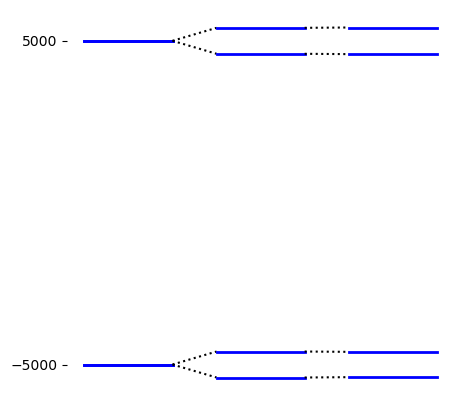

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
visualization.plot_energy_levels([H_LO/(2*np.pi*1e-3), H_NZ/(2*np.pi*1e-3), H_DD/(2*np.pi*1e-3)], 4, show_ylabels=True, ax=ax)
H0.eigenstates()[0]/(2*np.pi*1e-3) # Eigenenergies in kHz

In [9]:
H0.eigenstates()[1][0]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.00102216-0.00102216j]
 [0.99999896+0.j        ]]

# Pi pulse definition

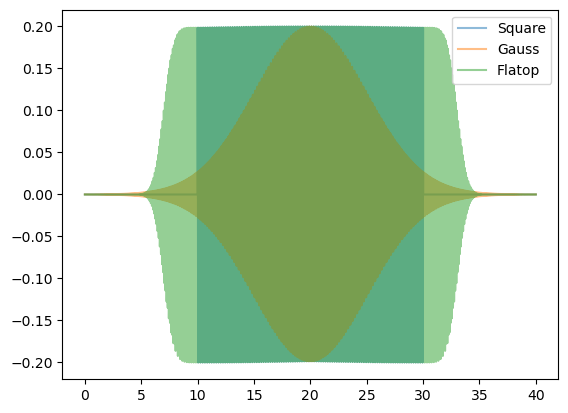

In [10]:
from scipy.special import erf
from cmath import exp

def ErfRising(t, sigma, amplitude, t0):
    return amplitude * (erf((t - t0) / sigma) + 1) / 2

def square_pulse(t, args):
    pulse_duration = args['pulse_duration']
    amplitude = args['amplitude']
    t0 = args['t0']
    detuning = args['detuning']
    phase = args['phase']
    if t > (t0 - pulse_duration/2) and t < (t0 + pulse_duration/2):
        return amplitude * np.cos((detuning+omega_LO)*t + phase)
    else:
        return 0

        
def gaussian_pulse(t, args):
    sigma = args['sigma_gauss']
    amplitude = args['amplitude']
    t0 = args['t0']
    detuning = args['detuning']
    phase = args['phase']
    if t > (t0-6*sigma) and t < (t0+6*sigma):
        return amplitude * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2)) * np.cos((detuning+omega_LO)*t + phase)
    else: 
        return 0

def flattop_pulse(t, args):
    pulse_duration = args['pulse_duration']
    sigma = args['sigma_raise']
    amplitude = args['amplitude']
    t0 = args['t0']
    detuning = args['detuning']
    phase = args['phase']
    if t > (t0 - pulse_duration/2 - 6*sigma) and t < (t0 - pulse_duration/2):
        return ErfRising(t, sigma, amplitude, t0 - pulse_duration/2 - 3*sigma) * np.cos((detuning+omega_LO)*t + phase)
        
    elif t > (t0 - pulse_duration/2) and t < (t0 + pulse_duration/2):
        return amplitude * np.cos((detuning+omega_LO)*t + phase)
        
    elif t > (t0 + pulse_duration/2) and t < (t0 + pulse_duration/2 + 6*sigma):
        return (amplitude-ErfRising(t, sigma, amplitude, t0 + pulse_duration/2 + 3*sigma)) * np.cos((detuning+omega_LO)*t + phase)
        
    else:
        return 0
    

args = {
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 20,
    'amplitude': 0.2,
    't0': 20,
    'detuning': 0,
    'phase': 0
    
}

t = np.linspace(0, 40, 5000)
p = [square_pulse(_t, args) for _t in t]
g = [gaussian_pulse(_t, args) for _t in t]
ft = [flattop_pulse(_t, args) for _t in t]
    
plt.figure()
plt.plot(t, p, alpha=0.5, label="Square")
plt.plot(t, g, alpha=0.5, label="Gauss")
plt.plot(t, ft, alpha=0.5, label="Flatop")
plt.legend()

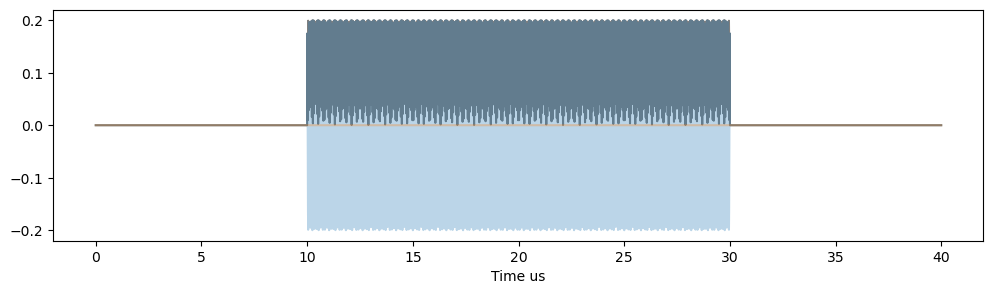

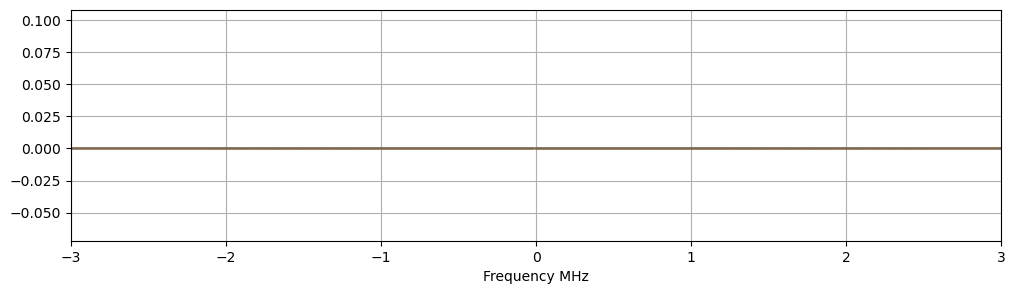

In [11]:
%matplotlib inline
from scipy.fft import fft, fftfreq
import numpy as np



args = {
    'sigma_raise': 1,
    'sigma_gauss': 5,
    'pulse_duration': 20,
    'amplitude': 0.2,
    't0': 20,
    'detuning': 2*np.pi*0.1,
    'phase': 0
    
}


# Number of sample points
N = 5000
# sample spacing
T = 40 / N
x = np.linspace(0.0, N*T, N, endpoint=False)
y = [square_pulse(_t, args) for _t in x]
yf = fft(y)
xf = fftfreq(N, T)

plt.figure(figsize=(12,3))
plt.plot(x, np.abs(y), 'k', alpha=0.5)
plt.plot(x, np.real(y), alpha=0.3)
plt.plot(x, np.imag(y), alpha=0.3)
plt.xlabel("Time us")

plt.figure(figsize=(12,3))
plt.plot(xf, 2.0/N * np.abs(yf), 'k', alpha=0.5)
plt.plot(xf, 2.0/N * np.real(yf), alpha=0.3)
plt.plot(xf, 2.0/N * np.imag(yf), alpha=0.3)
plt.xlim([-3, 3])
plt.xlabel("Frequency MHz")
plt.grid()
plt.show()

# Detuning measurement

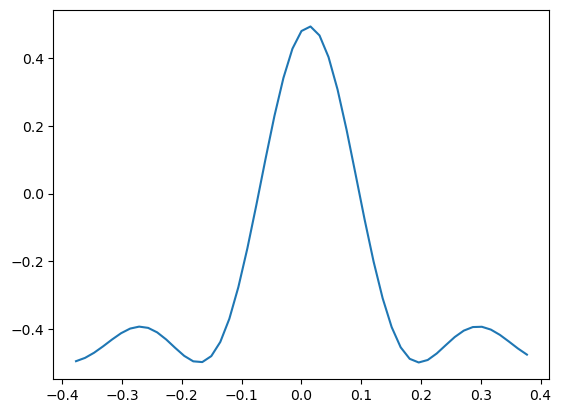

In [274]:
%matplotlib inline
ket0 = H0.eigenstates()[1][1] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

t = np.linspace(0, 40, 5000)
H_square = [tensor(sigmay(),qeye(nI)), square_pulse]

n_points = 51
detuning = A/2*np.linspace(-30, 30, n_points)

plot = False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

rab = []
for ii, det in enumerate(detuning):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 5,
        'pulse_duration': 30,
        'amplitude': 0.1,
        't0': 20,
        'detuning': det, # 2pi*f in MHz
        'phase': 0
    }
    
    result = mesolve([H0, H_square], ket0, t, [], [], args=args)
    rab.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, qeye(nI)), result.states), label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, [square_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

plt.figure()
plt.plot(detuning, rab)

# Rabi all pulses

In [347]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_square = [tensor(sigmay(),qeye(nI)), square_pulse]
H_gaussian = [tensor(sigmay(),qeye(nI)), gaussian_pulse]
H_flattop = [tensor(sigmay(),qeye(nI)), flattop_pulse]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
amplitudes = np.linspace(0, 0.4, 30)
t = np.linspace(0, 100, 2000)
sz_square = []
sz_gaussian = []
sz_falttop = []
for amp in amplitudes:
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 5,
        'pulse_duration': 30,
        'amplitude': amp,
        't0': 20,
        'detuning': -A/2, # 2pi*f in MHz
        'phase': 0
    }
    result = mesolve([H0, H_square], ket0, t, [], [], args=args)
    sz_square.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])

    result = mesolve([H0, H_gaussian], ket0, t, [], [], args=args)
    sz_gaussian.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args)
    sz_falttop.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])

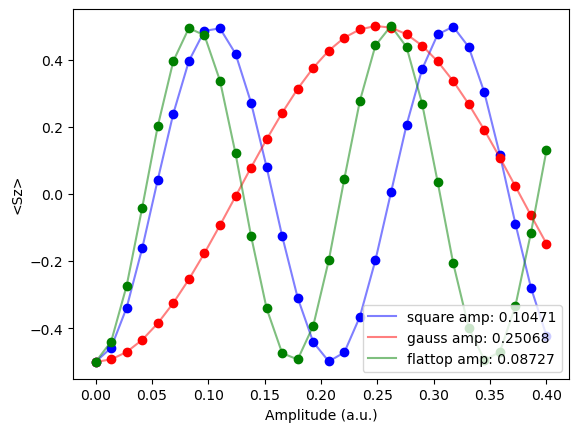

In [348]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

plt.figure()
guess = [5, 0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_square, guess)
plt.plot(amplitudes, sz_square, 'ob')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'b', alpha=0.5, label="square amp: %.5f"%(1/popt[0]/2))

guess = [3, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_gaussian, guess)
plt.plot(amplitudes, sz_gaussian, 'or')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'r', alpha=0.5, label="gauss amp: %.5f"%(1/popt[0]/2))

guess = [5, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_falttop, guess)
plt.plot(amplitudes, sz_falttop, 'og')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'g', alpha=0.5, label="flattop amp: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Selective excitation

In [332]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_gaussian = [tensor(sigmay(),qeye(nI)), gaussian_pulse]

ket0 = H0.eigenstates()[1][1] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
pi_amplitude = 0.2507
pi_duration = 5

n_points = 10
durations = np.linspace(1, 90, n_points)
amplitudes = pi_amplitude *  pi_duration / durations

plot=False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

t = np.linspace(0, 1000, 5000)
sz_gaussian = []
for ii, (amp, dur) in enumerate(zip(amplitudes, durations)):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': dur,
        'pulse_duration': 1,
        'amplitude': amp,
        't0': t[-1]/2,
        'detuning': -A/2, # 2pi*f in MHz
        'phase': 0
    }
    result = mesolve([H0, H_gaussian], ket0, t, [], [], args=args)
    sz_gaussian.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, qeye(nI)), result.states), label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, [gaussian_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()
    

(-0.01, 1.01)

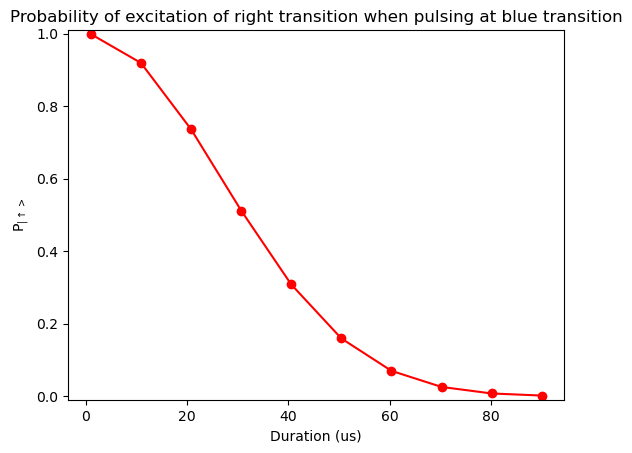

In [333]:
plt.plot(durations, 0.5+np.array(sz_gaussian), 'o-r')
plt.title("Probability of excitation of right transition when pulsing at blue transition")
plt.xlabel("Duration (us)")
plt.ylabel(r"P$_{|\uparrow>}$")
plt.ylim([-0.01, 1.01])


# Sideband flattop

Text(0.5, 0, 'Detuning (MHz)')

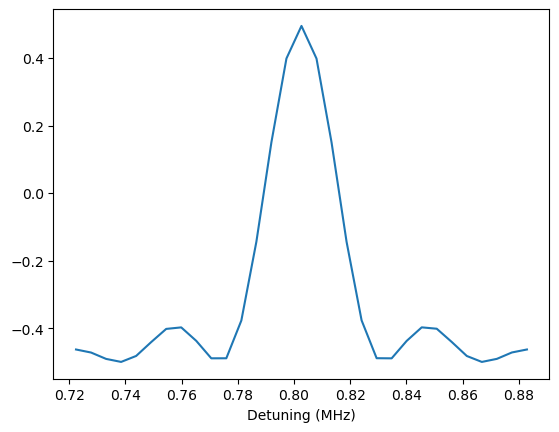

In [20]:
%matplotlib inline
ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

t = np.linspace(0, 40, 5000)
H_square = [tensor(sigmay(),sigmay()), square_pulse]

n_points = 31
detuning = omega_L*np.linspace(0.9, 1.1, n_points)

plot = False
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

rab = []
for ii, det in enumerate(detuning):
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 5,
        'pulse_duration': 30,
        'amplitude': 0.1,
        't0': 20,
        'detuning': det, # 2pi*f in MHz
        'phase': 0
    }
    
    result = mesolve([H0, H_square], ket0, t, [], [], args=args)
    rab.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    if plot:
        ax[ii].plot(t, expect(tensor(Sz, qeye(nI)), result.states), label="Detuning = %.2f kHz"%(det/2/np.pi*1e3))
        ax[ii].plot(t, [square_pulse(_t, args) for _t in t], alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

plt.figure()
plt.plot(detuning/2/np.pi, rab)
plt.xlabel("Detuning (MHz)")

In [35]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop = [tensor(sigmay(),sigmay()), square_pulse]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
amplitudes = np.linspace(0, 0.4, 30)
t = np.linspace(0, 100, 2000)
sz_square = []
sz_gaussian = []
sz_falttop = []
for amp in amplitudes:
    args = {
        'sigma_raise': 1,
        'sigma_gauss': 5,
        'pulse_duration': 30,
        'amplitude': amp,
        't0': 20,
        'detuning': omega_L, # 2pi*f in MHz
        'phase': 0
    }
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args)
    sz_falttop.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])

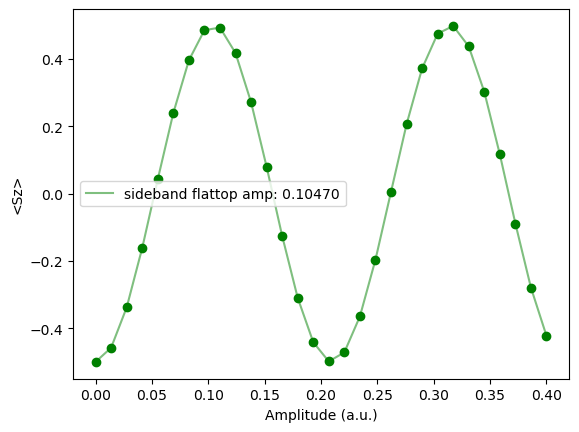

In [41]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

guess = [5, 0.5, 0]
popt, pcov = curve_fit(rabi_fit, amplitudes, sz_falttop, guess)
plt.plot(amplitudes, sz_falttop, 'og')
plt.plot(amplitudes, rabi_fit(amplitudes, *popt), 'g', alpha=0.5, label="sideband flattop amp: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Composite 3 pulse Rabi

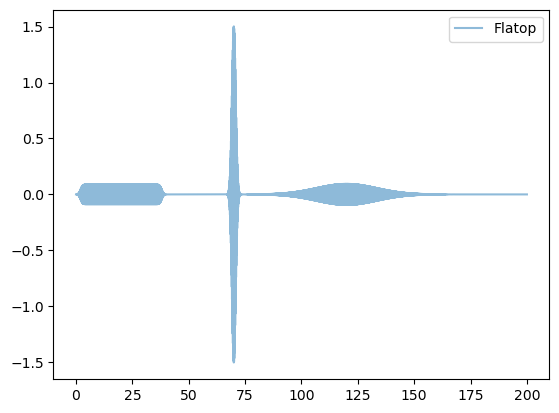

In [63]:
def three_pulse_train(t, args):
    args_flattop_sb = {
        'pulse_duration': args['pulse_duration_ft'],
        'sigma_raise':    args['sigma_raise_ft'],
        'amplitude':      args['amplitude_ft'],
        't0':             args['t0_ft'] + args['sequence_delay'], 
        'detuning':       args['detuning_sb'],
        'phase':          args['phase'],
    }
    args_gauss_us = {
        'sigma_gauss':    args['sigma_gauss_g1'],
        'amplitude':      args['amplitude_g1'],
        't0':             args['t0_g1'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_s = {
        'sigma_gauss':    args['sigma_raise_g2'],
        'amplitude':      args['amplitude_g2'],
        't0':             args['t0_g2'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    return flattop_pulse(t, args_flattop_sb) + gaussian_pulse(t, args_gauss_us) + gaussian_pulse(t, args_gauss_s)

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872
sb_t = 20

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t = 20 + 50

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t = 20 + 50 + 50

phase = 0

args_3_composite = {
        'pulse_duration_ft': sb_duration,
        'sigma_raise_ft': sb_rise,
        'amplitude_ft': sb_amplitude,
        't0_ft': sb_t,

        'sigma_gauss_g1': us_duration,
        'amplitude_g1': us_amplitude,
        't0_g1': us_t,
                      
        'sigma_raise_g2': s_duration,
        'amplitude_g2': s_amplitude,
        't0_g2': s_t,
    
        'sequence_delay': 0 ,         
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 200, 100000)
ft3 = [three_pulse_train(_t, args_3_composite) for _t in t]
    
plt.figure()
plt.plot(t, ft3, alpha=0.5, label="Flatop")
plt.legend()

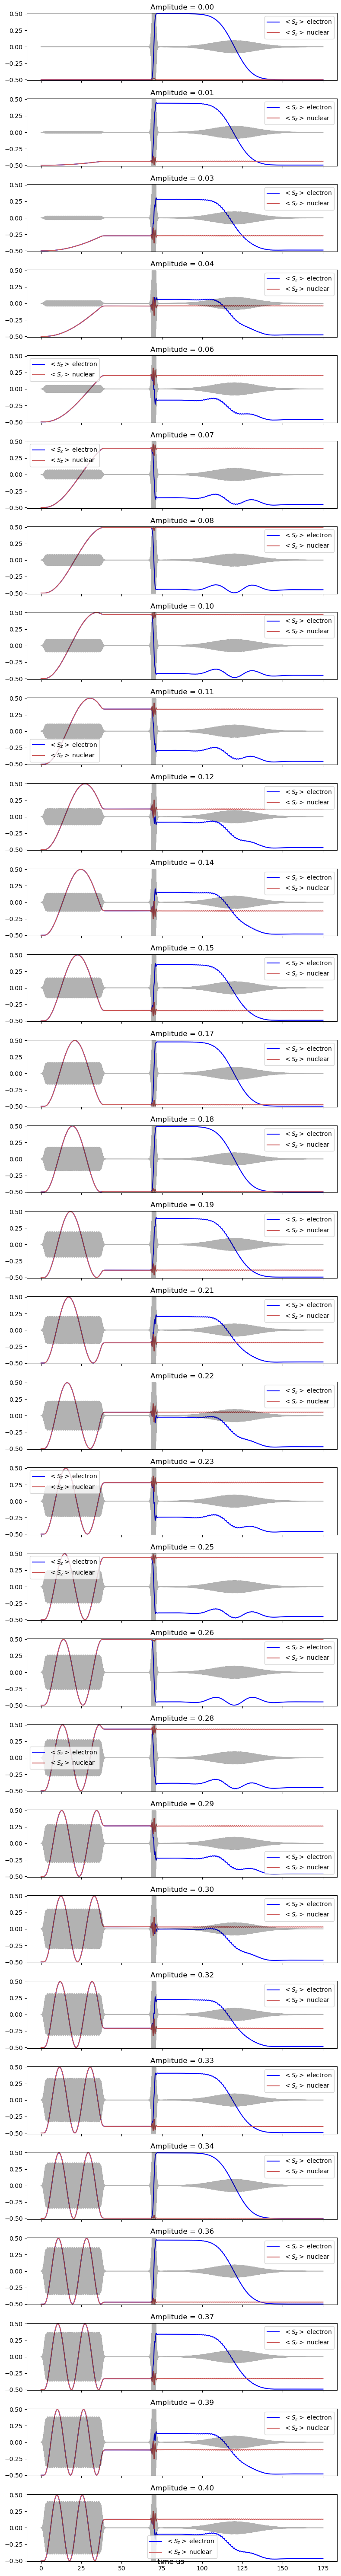

In [35]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)), three_pulse_train]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 30
amplitudes = np.linspace(0, 0.4, n_points)
t = np.linspace(0, 175, 5000)

plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, amp in enumerate(amplitudes):
    args_3_composite["amplitude_ft"] = amp
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args_3_composite)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Amplitude = %.2f"%(amp))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [three_pulse_train(_t, args_3_composite) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

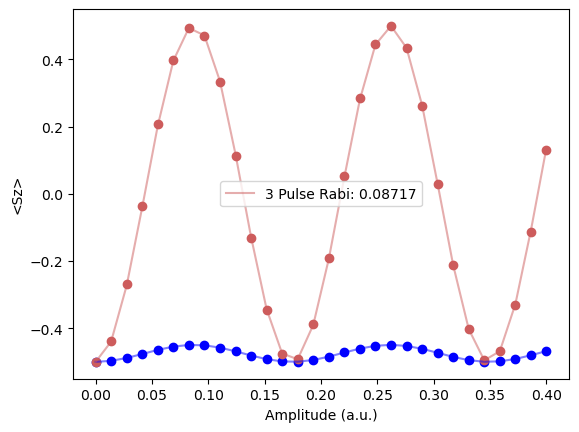

In [38]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]
guess = [5, 0.5, 0]
popt_e, pcov_e = curve_fit(rabi_fit, amplitudes, sz_electron_end, guess)
popt_n, pcov_n = curve_fit(rabi_fit, amplitudes, sz_nuclear_end, guess)

plt.plot(amplitudes, sz_electron_end, 'o', color="b")
plt.plot(amplitudes, sz_nuclear_end, 'o', color="indianred")

plt.plot(amplitudes, rabi_fit(amplitudes, *popt_e), 'b', alpha=0.5)
plt.plot(amplitudes, rabi_fit(amplitudes, *popt_n), 'indianred', alpha=0.5, label="3 Pulse Rabi: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Composite 5 pulse Rabi

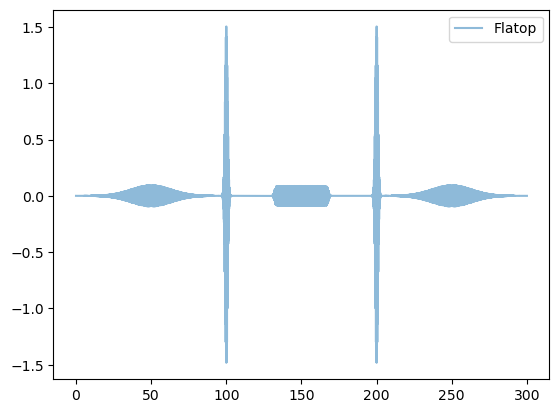

In [51]:
def five_pulse_train(t, args):
    args_gauss_s1 = {
        'sigma_gauss':    args['s_sigma_gauss'],
        'amplitude':      args['s_amplitude'],
        't0':             args['s_t1'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_us1 = {
        'sigma_gauss':    args['us_sigma_gauss'],
        'amplitude':      args['us_amplitude'],
        't0':             args['us_t2'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_flattop_sb = {
        'pulse_duration': args['sb_pulse_duration'],
        'sigma_raise':    args['sb_sigma_raise'],
        'amplitude':      args['sb_amplitude'],
        't0':             args['sb_t0'],
        'detuning':       args['detuning_sb'],
        'phase':          args['phase'],
    }
    args_gauss_us2 = {
        'sigma_gauss':    args['us_sigma_gauss'],
        'amplitude':      args['us_amplitude'],
        't0':             args['us_t3'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_s2 = {
        'sigma_gauss':    args['s_sigma_gauss'],
        'amplitude':      args['s_amplitude'],
        't0':             args['s_t4'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    outpulse = (
        gaussian_pulse(t, args_gauss_s1) + gaussian_pulse(t, args_gauss_us1) +
        flattop_pulse(t, args_flattop_sb) + 
        gaussian_pulse(t, args_gauss_us2)  + gaussian_pulse(t, args_gauss_s2)
    )
    return outpulse

pulse_delay = 50

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872
sb_t = pulse_delay*3

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t2 = pulse_delay*2
us_t3 = pulse_delay*4

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t1 = pulse_delay
s_t4 = pulse_delay*5

phase = 0

args_5_composite = {
        'sb_pulse_duration': sb_duration,
        'sb_sigma_raise': sb_rise,
        'sb_amplitude': sb_amplitude,
        'sb_t0': sb_t,

        'us_sigma_gauss': us_duration,
        'us_amplitude': us_amplitude,
        'us_t2': us_t2,
        'us_t3': us_t3,
                      
        's_sigma_gauss': s_duration,
        's_amplitude': s_amplitude,
        's_t1': s_t1,
        's_t4': s_t4,
                      
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 6*pulse_delay, 10000)
ft5 = [five_pulse_train(_t, args_5_composite) for _t in t]
    
plt.figure()
plt.plot(t, ft5, alpha=0.5, label="Flatop")
plt.legend()

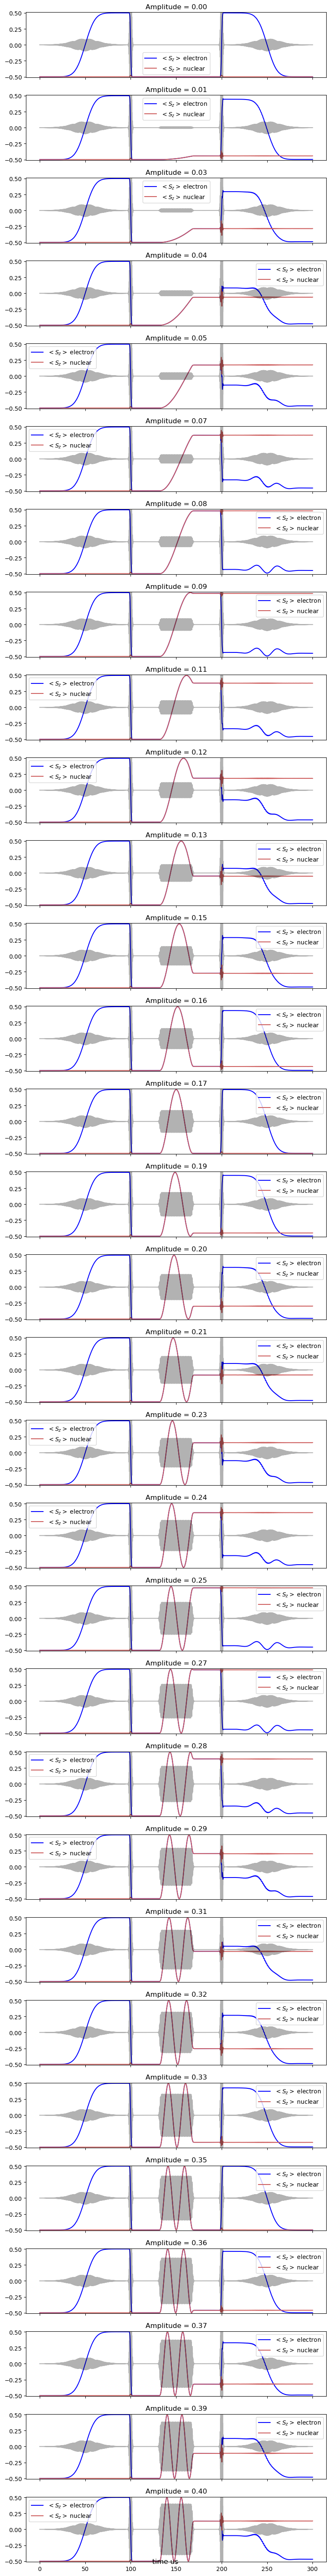

In [57]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_flattop = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)), five_pulse_train]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 31
amplitudes = np.linspace(0, 0.4, n_points)
t = np.linspace(0, 6*pulse_delay, 5000)

plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, amp in enumerate(amplitudes):
    args_5_composite["sb_amplitude"] = amp
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args_5_composite)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Amplitude = %.2f"%(amp))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [five_pulse_train(_t, args_5_composite) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

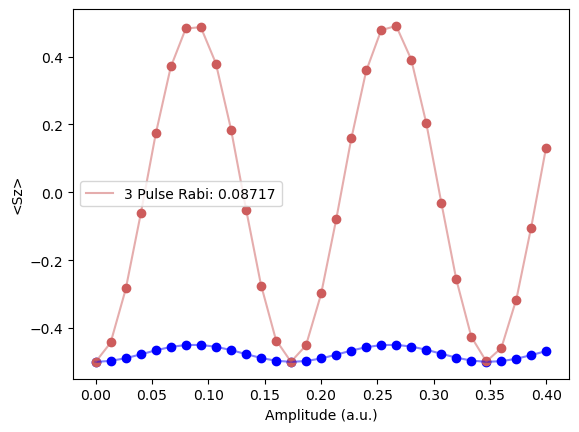

In [58]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]
guess = [5, 0.5, 0]
popt_e, pcov_e = curve_fit(rabi_fit, amplitudes, sz_electron_end, guess)
popt_n, pcov_n = curve_fit(rabi_fit, amplitudes, sz_nuclear_end, guess)

plt.plot(amplitudes, sz_electron_end, 'o', color="b")
plt.plot(amplitudes, sz_nuclear_end, 'o', color="indianred")

plt.plot(amplitudes, rabi_fit(amplitudes, *popt_e), 'b', alpha=0.5)
plt.plot(amplitudes, rabi_fit(amplitudes, *popt_n), 'indianred', alpha=0.5, label=" Pulse Rabi: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()

# Nuclear Ramsey Sequence

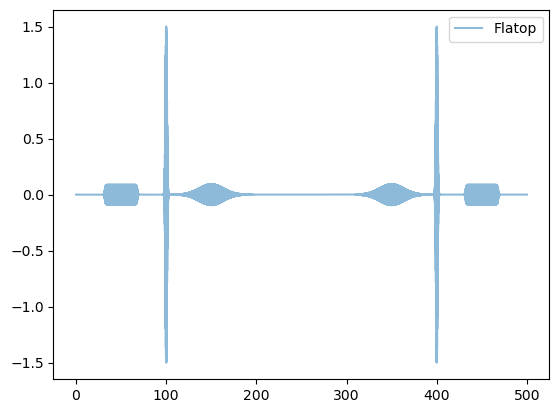

In [106]:
def three_pulse_train_ramsey(t, args):
    args_flattop_sb1 = {
        'pulse_duration': args['pulse_duration_ft'],
        'sigma_raise':    args['sigma_raise_ft'],
        'amplitude':      args['amplitude_ft'],
        't0':             args['t0_ft'] + args['sequence_delay'], 
        'detuning':       args['detuning_sb'],
        'phase':          args['phase'],
    }
    args_gauss_us1 = {
        'sigma_gauss':    args['sigma_gauss_g1'],
        'amplitude':      args['amplitude_g1'],
        't0':             args['t0_g1'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    args_gauss_s1 = {
        'sigma_gauss':    args['sigma_raise_g2'],
        'amplitude':      args['amplitude_g2'],
        't0':             args['t0_g2'] + args['sequence_delay'],
        'detuning':       args['detuning_b'],
        'phase':          args['phase'],
    }
    
    args_gauss_s2 = args_gauss_s1.copy()
    args_gauss_s2['t0'] =  args_gauss_s1['t0'] + args['t0_ft'] + args["ramsey_delay"]
    
    args_gauss_us2 = args_gauss_us1.copy()
    args_gauss_us2['t0'] =  args_gauss_s1['t0'] + args['t0_g1'] + args["ramsey_delay"]

    args_flattop_sb2 = args_flattop_sb1.copy()
    args_flattop_sb2['t0'] =  args_gauss_s1['t0'] + args['t0_g2'] + args["ramsey_delay"]
    args_flattop_sb2['phase'] =  ramsey_detuning*t
    
    outpulse = (
        flattop_pulse(t, args_flattop_sb1) + gaussian_pulse(t, args_gauss_us1) + gaussian_pulse(t, args_gauss_s1) + 
        gaussian_pulse(t, args_gauss_s2) + gaussian_pulse(t, args_gauss_us2) + flattop_pulse(t, args_flattop_sb2) 
    )
    
    return outpulse

ramsey_detuning = 0
sequence_delay = 50
ramsey_delay = 200
pulse_delay = 50
phase = 0

# Calculated using the rabi pulses on section Rabi all pulses and sideband falttop
sb_duration = 30
sb_rise = 1
sb_amplitude = 0.0872
sb_t = 0

us_duration = 5 / 6
us_amplitude = 0.2507 * 6
us_t = pulse_delay

s_duration = 80 / 6
s_amplitude = us_amplitude / s_duration * us_duration 
s_t = pulse_delay*2


args = {
        'pulse_duration_ft': sb_duration,
        'sigma_raise_ft': sb_rise,
        'amplitude_ft': sb_amplitude,
        't0_ft': sb_t,

        'sigma_gauss_g1': us_duration,
        'amplitude_g1': us_amplitude,
        't0_g1': us_t,
                      
        'sigma_raise_g2': s_duration,
        'amplitude_g2': s_amplitude,
        't0_g2': s_t,

        'ramsey_detuning': ramsey_detuning,
        'sequence_delay': sequence_delay,
        'ramsey_delay': ramsey_delay,
        'detuning_sb': omega_L,
        'detuning_b': -A/2,
        'phase': phase,
}

t = np.linspace(0, 5*pulse_delay + sequence_delay + ramsey_delay, 100000)
ft3 = [three_pulse_train_ramsey(_t, args) for _t in t]
    
plt.figure()
plt.plot(t, ft3, alpha=0.5, label="Flatop")
plt.legend()

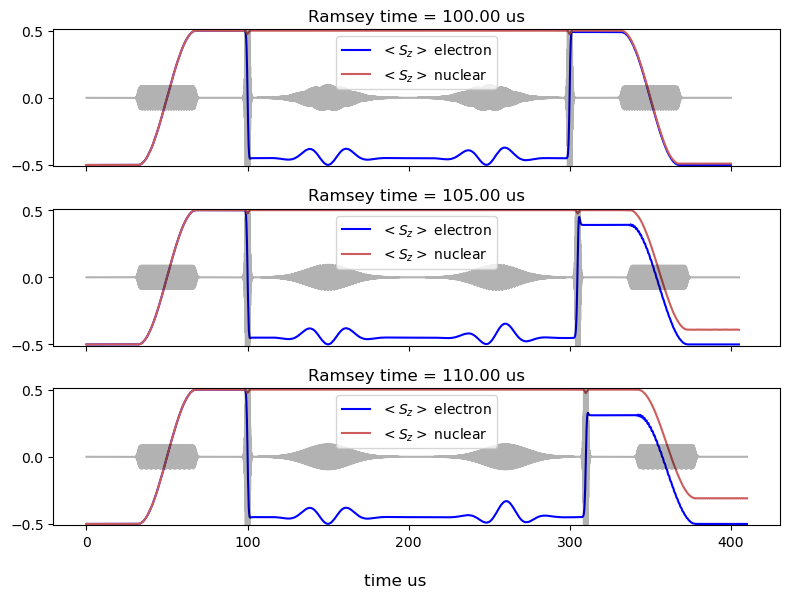

In [115]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_pulses = [tensor(sigmay(),sigmay()) + tensor(sigmay(),qeye(nI)), three_pulse_train_ramsey]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
n_points = 3
ramsey_times = np.linspace(100, 110, n_points)


plot=True
if plot:
    fig, ax = plt.subplots(n_points, 1, figsize=(8, 2*n_points), sharex=True, tight_layout=True)
    fig.supxlabel("time us")

sz_electron = []
sz_nuclear = []

for ii, ramsey_delay in enumerate(ramsey_times):
    args["ramsey_delay"] = ramsey_delay
    t = np.linspace(0, 5*pulse_delay + sequence_delay + ramsey_delay, 10001)
    
    result = mesolve([H0, H_pulses], ket0, t, [], [], args=args)
    sz_electron.append(expect(tensor(Sz, qeye(nI)), result.states))
    sz_nuclear.append(expect(tensor(qeye(nS), Sz), result.states))
    if plot:
        ax[ii].set_title("Ramsey time = %.2f us"%(ramsey_delay))
        ax[ii].plot(t, sz_electron[-1], "b", label=r"$<S_z>$ electron")
        ax[ii].plot(t, sz_nuclear[-1], "indianred", label=r"$<S_z>$ nuclear")
        ax[ii].plot(t, [three_pulse_train_ramsey(_t, args) for _t in t], "k", alpha=0.3)
        ax[ii].set_ylim([-0.51, 0.51])
        ax[ii].legend()

plt.savefig("figs/fig.pdf")

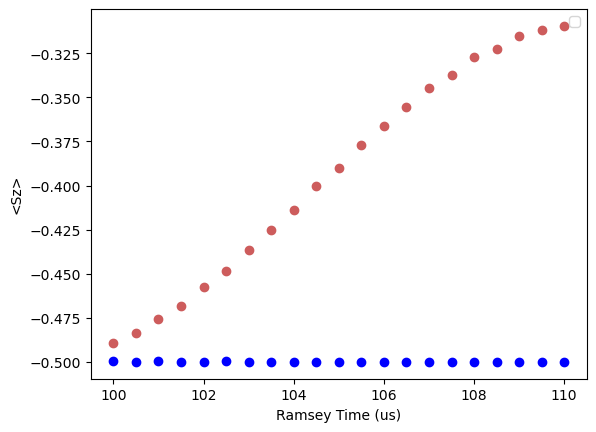

In [110]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

sz_electron_end = np.array(sz_electron)[:, -1]
sz_nuclear_end = np.array(sz_nuclear)[:, -1]

plt.plot(ramsey_times, sz_electron_end, 'o', color="b")
plt.plot(ramsey_times, sz_nuclear_end, 'o', color="indianred")

plt.xlabel("Ramsey Time (us)")
plt.ylabel("<Sz>")
plt.legend()